In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [3]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.325,41.000,6.984,1.024,322.000,2.556,37.880,-122.230
1,8.301,21.000,6.238,0.972,2401.000,2.110,37.860,-122.220
2,7.257,52.000,8.288,1.073,496.000,2.802,37.850,-122.240
3,5.643,52.000,5.817,1.073,558.000,2.548,37.850,-122.250
4,3.846,52.000,6.282,1.081,565.000,2.181,37.850,-122.250


> El objetivo es predecir el retraso de llegada

In [4]:
target.describe()

count   20640.000
mean        2.069
std         1.154
min         0.150
25%         1.196
50%         1.797
75%         2.647
max         5.000
Name: MedHouseVal, dtype: float64

> El objetivo es predecir el retraso de llegada

# Training error vs testing error

In [6]:
# Con un DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [7]:
# Después de entrenar el regresor, nos gustaría saber su generalización potencial
# rendimiento una vez implementado en producción.
# Para este propósito, usamos el error absoluto medio,
# lo que nos da un error en la unidad nativa.

from sklearn.metrics import mean_absolute_error, r2_score

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
r2 = r2_score(target, target_predicted)
print('Nuestro regresor hace:')
print(f"mean_absolute_error de {score:.2f}")
print(f"r2 de {r2:.2f}")

Nuestro regresor hace:
mean_absolute_error de 0.00
r2 de 1.00


La evaluación más básica implica:
- dividir nuestro conjunto de datos en dos subconjuntos: un conjunto de entrenamiento y un conjunto de prueba;
- ajuste del modelo en el conjunto de entrenamiento;
- estimar el error de entrenamiento en el conjunto de entrenamiento;
- estimar el error de prueba en el conjunto de prueba.

In [8]:
# dividimos nuestro conjunto de datos.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

In [9]:
# entrenamos nuestro modelo.

regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

In [10]:
# Finalmente, estimamos los diferentes tipos de errores.
# el error de entrenamiento.

target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"El error de entrenamiento es {score:.2f}")

El error de entrenamiento es 0.00


In [11]:
# el error de prueba.

target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"El error de prueba es {score:.2f}")

El error de prueba es 0.47


# Estabilidad de las estimaciones de validación cruzada
La **validación cruzada** permite estimar la **robustez de un modelo predictivo** repitiendo el procedimiento de división. Dará varios errores de entrenamiento y prueba y, por lo tanto, alguna estimación de la variabilidad del rendimiento de generalización del modelo.

Existen diferentes estrategias de validación cruzada, por ahora nos vamos a centrar en una llamada **“shuffle-split”**. En cada iteración de esta estrategia:
- mezclar aleatoriamente el orden de las muestras de una copia del conjunto de datos completo;
- dividir el conjunto de datos barajados en un tren y un conjunto de prueba;
- entrenar un nuevo modelo en el juego de trenes;
- evaluar el error de prueba en el equipo de prueba.

Repetimos este procedimiento n_splits veces. Hay que tener en cuenta que el coste computacional aumenta con n_splits.

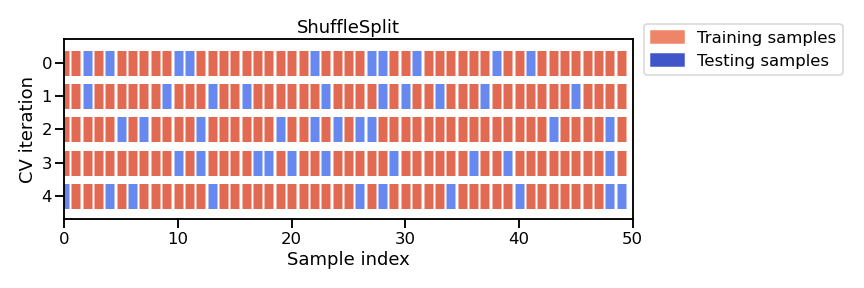

En este caso estableceremos n_splits=40, lo que significa que entrenaremos 40 modelos en total y todos serán descartados: solo registramos su **desempeño de generalización en cada variante del conjunto de prueba**.

In [12]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [13]:
# Los resultados cv_results se almacenan en un diccionario Python.
# Lo convertiremos en un marco de datos de pandas para facilitar la visualización y manipulación.

import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.246,0.005,-0.466
1,0.231,0.005,-0.472
2,0.230,0.004,-0.472
3,0.238,0.004,-0.447
4,0.455,0.006,-0.474


In [14]:
# revertimos los negativos
cv_results["test_error"] = -cv_results["test_score"]

# verificamos los resultados
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.246,0.005,-0.466,0.466
1,0.231,0.005,-0.472,0.472
2,0.230,0.004,-0.472,0.472
3,0.238,0.004,-0.447,0.447
4,0.455,0.006,-0.474,0.474
5,0.303,0.005,-0.466,0.466
6,0.265,0.010,-0.466,0.466
7,0.270,0.006,-0.460,0.460
8,0.272,0.007,-0.455,0.455
9,0.253,0.005,-0.454,0.454


In [15]:
len(cv_results)

40

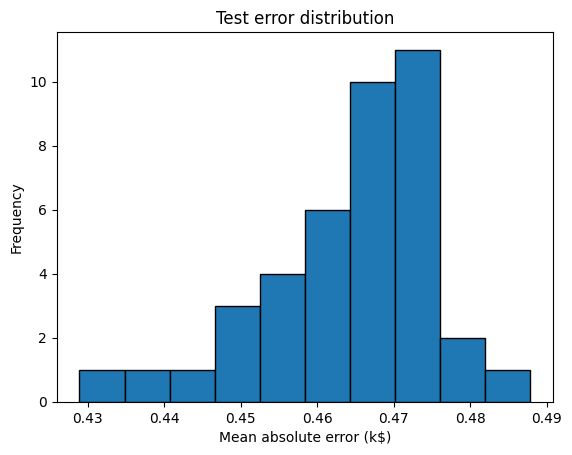

In [16]:
# Obtenemos 40 entradas en nuestro marco de datos resultante porque realizamos 40 divisiones.
# Por lo tanto, podemos mostrar la distribución del error de prueba y así tener una estimación de su variabilidad.

import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [17]:
print(f"La media del cross-validated testing error es: "
      f"{cv_results['test_error'].mean():.2f}")

La media del cross-validated testing error es: 0.46


In [18]:
print(f"La desviación estandar del testing error es: "
      f"{cv_results['test_error'].std():.2f}")

La desviación estandar del testing error es: 0.01


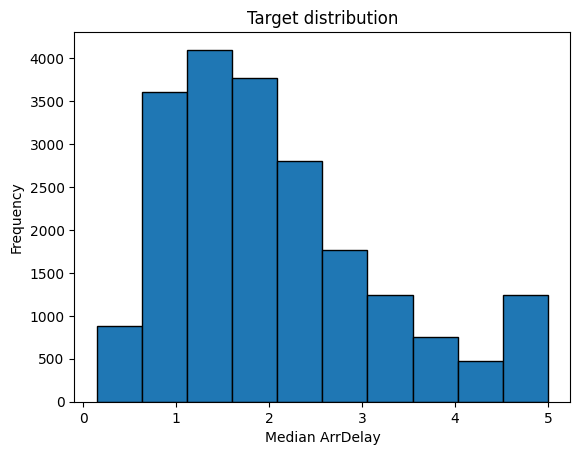

In [19]:
# Tracemos la distribución de la variable target

target.plot.hist(edgecolor="black")
plt.xlabel("Median ArrDelay")
_ = plt.title("Target distribution")

In [ ]:
print(f"La desviación estándar del target es: {target.std():.2f}")

In [20]:
# En el caso de que solo esté interesado en el score de la prueba,
# scikit-learn proporciona la función cross_val_score.
# Es idéntico a llamar a la función cross_validate y seleccionar solo test_score.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.25280448, 0.38292026, 0.45167324, 0.22590099, 0.40581787])